In [1]:
#-*- coding: utf-8 -*-

import tensorflow as tf
# dont display much info of tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any level you prefer

# limit gpu memory usage only as much as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        print("Setting memory growth to True for GPU: ", gpu)
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print("Physical GPUs: ", len(gpus), "Logical GPUs: ", len(logical_gpus))
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Concatenate, Add, AveragePooling2D
import numpy as np

import matplotlib.pyplot as plt


2024-01-02 17:07:47.902405: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-02 17:07:47.945395: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 17:07:47.945421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 17:07:47.947348: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 17:07:47.956973: I tensorflow/core/platform/cpu_feature_guar

Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Physical GPUs:  1 Logical GPUs:  1


In [2]:

# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path)
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

#feats = np.load(feats_path)
#print("feats shape: ", feats.shape)
y = y[:, 0] # only use laser power
print("y shape: ", y.shape)

# normalize y
y = y / np.max(y)

manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
y shape:  (9587, 2)
y shape:  (9587,)


In [3]:
# unique values in y
y_unique = np.unique(y)
print("unique values in y: ", y_unique)

# encode y as integers based on unique values
y_encoded = np.zeros(y.shape)
for i in range(len(y_unique)):
    y_encoded[y == y_unique[i]] = i
print("y encoded: ", y_encoded)
# change to int
y_encoded = y_encoded.astype(int)

# print typr of y_encoded
print("y encoded type: ", type(y_encoded[0]))

unique values in y:  [0.18181818 0.45454545 0.72727273 1.        ]
y encoded:  [0. 0. 0. ... 3. 3. 3.]
y encoded type:  <class 'numpy.int64'>


In [5]:
# crate pairs
def create_pairs(manta, xiris, y_encoded):
    # set seed
    np.random.seed(42)
        
    pairs = []
    labels = []
    
    # Getting the indices of each class
    numclasses = len(np.unique(y_encoded))
    idx = [np.where(y_encoded==i)[0] for i in range(numclasses)]

    for idxA in range(len(y_encoded)):
        # grab the current image and label belonging to the current iteration
        currentImage = manta[idxA]
        label = y_encoded[idxA]

        # randomly pick an image that belongs to the same class label
        idxB = np.random.choice(idx[label])
        posImage = xiris[idxB]

        # prepare a positive pair and update the images and labels lists, respectively
        pairs.append([currentImage, posImage])
        labels.append([0])

        # grab the indices for each of the class labels not equal to the current label
        negIdx = np.where(y_encoded != label)[0]
        
        # randomly pick an image corresponding to a label not equal to the current label
        idxC = np.random.choice(negIdx)
        label2 = y_encoded[idxC]
        negImage = xiris[idxC]
        
        # prepare a negative pair of images and update our lists
        pairs.append([currentImage, negImage])
        labels.append([1])

        if idxA % 1000 == 0:
            print(f"Creating pairs for image {idxA}/{len(y_encoded)}, Completed {int(idxA/len(y_encoded)*100)}%")
    
    return np.array(pairs), np.array(labels)       

                                                                                            
# create pairs
pairs, labels = create_pairs(manta, xiris, y_encoded)
print("pairs shape: ", pairs.shape)
print("labels shape: ", labels.shape)

# split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42, shuffle=True)
print(f"X_train shape: {X_train.shape} ",f"y_train shape: {y_train.shape} ")
print(f"X_test shape: {X_test.shape} ",f"y_test shape: {y_test.shape} ")


Creating pairs for image 0/9587, Completed 0%
Creating pairs for image 1000/9587, Completed 10%
Creating pairs for image 2000/9587, Completed 20%
Creating pairs for image 3000/9587, Completed 31%
Creating pairs for image 4000/9587, Completed 41%
Creating pairs for image 5000/9587, Completed 52%
Creating pairs for image 6000/9587, Completed 62%
Creating pairs for image 7000/9587, Completed 73%
Creating pairs for image 8000/9587, Completed 83%
Creating pairs for image 9000/9587, Completed 93%
pairs shape:  (19174, 2, 320, 320)
labels shape:  (19174, 1)
X_train shape: (15339, 2, 320, 320)  y_train shape: (15339, 1) 
X_test shape: (3835, 2, 320, 320)  y_test shape: (3835, 1) 


In [9]:
#!pip3 install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 33.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 11.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 19.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 8.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 14.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 4.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:0000:0100:01
     

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import Dataset

class SiameseDataset(Dataset):
    def __init__(self, pairs, labels, transform=None):
        self.pairs = pairs
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        pair = self.pairs[index]
        label = self.labels[index]

        img1 = pair[0]
        img2 = pair[1]

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.pairs)


In [20]:
from torchvision.transforms.functional import to_pil_image

class SiameseDataset(Dataset):
    def __init__(self, pairs, labels, transform=None):
        self.pairs = pairs
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        pair = self.pairs[index]
        label = self.labels[index]

        img1 = pair[0]
        img2 = pair[1]

        # Ensure the images are converted to PIL Images or ndarrays
        img1 = to_pil_image(img1)
        img2 = to_pil_image(img2)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.pairs)


In [21]:
# Siamese Network Definition
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=128):
        super(SiameseNetwork, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, embedding_dim),
        )

    def forward_one(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

# Contrastive Loss with Margin
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                     (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train[:, 0], dtype=torch.float32)  # Fix the indexing here
y_test_tensor = torch.tensor(y_test[:, 0], dtype=torch.float32)    # Fix the indexing here

# Create custom datasets and data loaders
train_dataset = SiameseDataset(X_train_tensor, y_train_tensor, transform=transforms.ToTensor())
test_dataset = SiameseDataset(X_test_tensor, y_test_tensor, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model, Loss, and Optimizer
model = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_loader:
        img1, img2, label = batch

        # Convert input data to float
        img1 = img1.float()
        img2 = img2.float()

        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



/tmp/ipykernel_36867/1367684560.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return img1, img2, torch.tensor(label, dtype=torch.float32)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x313600 and 9216x512)

In [5]:
y_test

array([[2, 0, 1],
       [1, 3, 1],
       [0, 0, 0],
       ...,
       [2, 2, 0],
       [1, 1, 0],
       [3, 3, 0]])

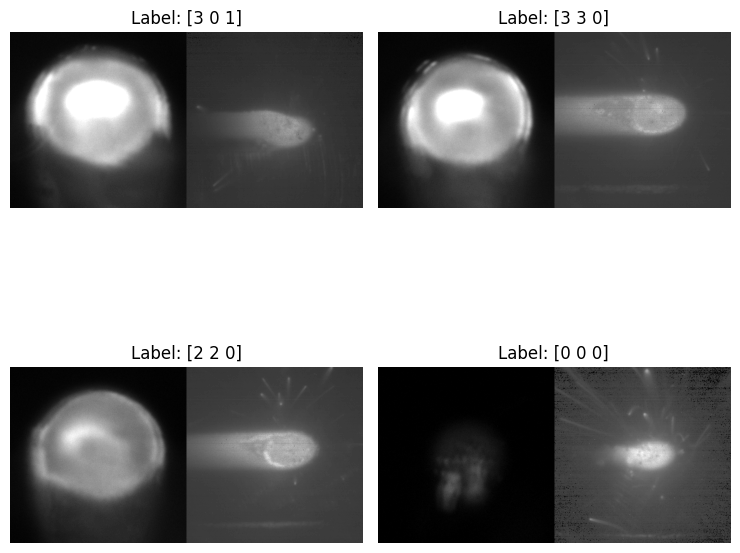

In [6]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.keras.layers.concatenate([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

# visualize pairs
visualize(X_train, y_train, to_show=4, num_col=2)

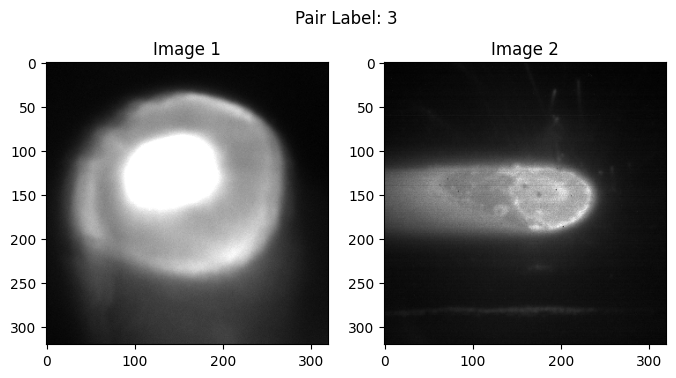

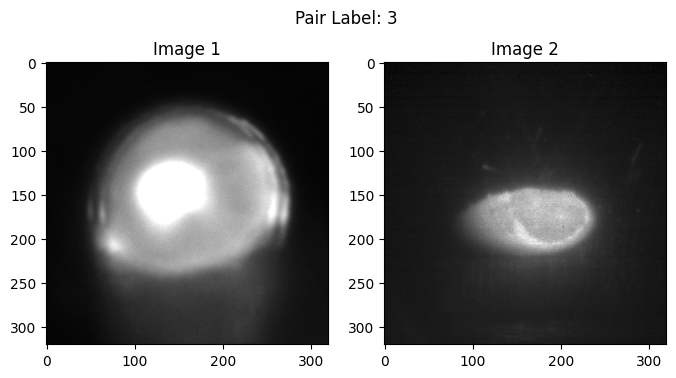

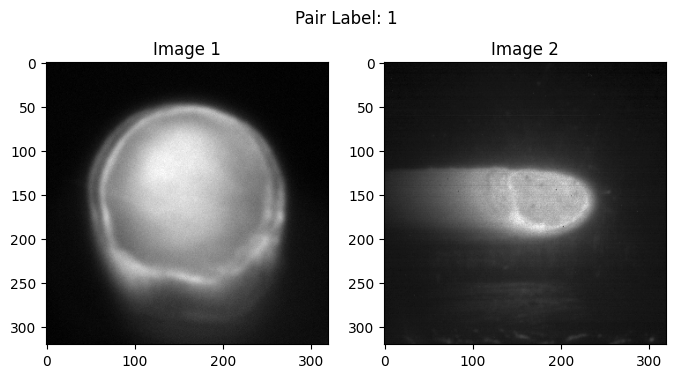

In [7]:
# Verify a few pairs visually
num_samples_to_verify = 3

for i in range(num_samples_to_verify):
    sample_idx = np.random.randint(0, len(X_train))
    pair = X_train[sample_idx]
    label = y_train[sample_idx]

    # Extract images from the pair
    image1, image2 = pair[0], pair[1]

    # Display images with their corresponding label
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.title('Image 1')

    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap='gray')
    plt.title('Image 2')

    plt.suptitle(f"Pair Label: {label[0]}")
    plt.show()


In [8]:
def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    model = Model(inputs=inputs, outputs=x)
    return model

# add projection head
def add_projection_head(input_shape, encoder, embedding_dim):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)
    outputs = Dense(embedding_dim, activation='relu')(features)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
def euclidean_distance(vecs):
    """Find the Euclidean distance between two vectors. L2-distance.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """
    
    (imgA, imgB) = vecs
    
    # Calculate squared Euclidean distance
    squared_diff = tf.square(imgA - imgB)
    sum_squared_diff = tf.reduce_sum(squared_diff, axis=1, keepdims=True)
    
    # Take the square root with epsilon for numerical stability
    euclidean_dist = tf.sqrt(tf.maximum(sum_squared_diff, tf.keras.backend.epsilon()))
    
    return euclidean_dist       

def contrastiveloss(y, y_preds, margin=1):
    y = tf.cast(y, dtype=y_preds.dtype)

    # Calculate squared y_preds and margin
    y_preds_squared = tf.square(y_preds)
    margin_squared = tf.square(tf.maximum(margin - y_preds, 0))

    # Compute the loss
    return tf.reduce_mean(y * y_preds_squared + (1 - y) * margin_squared) # positive + negative loss

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [10]:
def contrastive_loss_with_margin(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        # Ensure that y_true is of type float32
        y_true = tf.cast(y_true, dtype=tf.float32)

        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

def contrastive_loss_with_margin2(margin=1):
    def contrastive_loss(y_true, y_pred):
        binary_flag = tf.cast(y_true[:, -1], dtype=tf.float32)

        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        
        
        return tf.reduce_mean((1 - binary_flag) * square_pred + (binary_flag) * margin_square)

    return contrastive_loss

def accuracy2(y_true, y_pred):
    y_true2 = tf.cast(y_true[:, -1], dtype=tf.float32)
    return tf.reduce_mean(tf.cast(tf.equal(y_true2, tf.cast(y_pred < 0.5, y_true2.dtype)), tf.float32))

In [11]:
input_shape = (320, 320, 1)
embedding_dim= 128
batch_size = 64
epochs = 10
learning_rate = 0.0001


manta = Input(shape=input_shape)
xiris = Input(shape=input_shape)

encoder = create_encoder(input_shape)
encoder_with_projection_head = add_projection_head(input_shape, encoder, embedding_dim)
#encoder_with_projection_head.summary()

manta_encoded = encoder_with_projection_head(manta)
xiris_encoded = encoder_with_projection_head(xiris)
# Assuming encoded_l and encoded_r are your two input tensors
distance = tf.abs(manta_encoded - xiris_encoded)
output = tf.keras.layers.Dense(1, activation="linear")(distance)

siamese_net = tf.keras.Model(inputs=[manta, xiris], outputs=output)

siamese_net.compile(loss=contrastive_loss_with_margin2(margin=1.0), #contrastive_loss_with_margin2(margin=1.0),
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), #optimizer=tf.keras.optimizers.RMSprop()
                    metrics=[accuracy2])
siamese_net.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 128)                  2492499   ['input_1[0][0]',             
                                                          2          'input_2[0][0]']             
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 128)                  0         ['model_1[0][0]',       

In [12]:
#y_train = y_train[:, -1]
y_train

array([[3, 0, 1],
       [3, 3, 0],
       [2, 2, 0],
       ...,
       [1, 1, 0],
       [0, 0, 0],
       [3, 0, 1]])

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

def contrastive_loss_with_margin(margin=1):
    def contrastive_loss(y_true, y_pred):
        binary_flag = tf.cast(y_true[:, -1], dtype=tf.float32)
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean((1 - binary_flag) * square_pred + binary_flag * margin_square)

    return contrastive_loss

def accuracy(y_true, y_pred):
    threshold=0.5
    binary_flag = tf.cast(y_true[:, -1], dtype=tf.float32)
    
    # Use a custom threshold for predictions
    predicted_binary_labels = tf.cast(y_pred < threshold, tf.float32)
    
    # Compare predicted labels with true labels and calculate accuracy
    correct_predictions = tf.equal(binary_flag, predicted_binary_labels)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    return accuracy

input_shape = (320, 320, 1)
embedding_dim = 128
learning_rate = 0.001

manta = Input(shape=input_shape)
xiris = Input(shape=input_shape)

encoder = create_encoder(input_shape)
encoder_with_projection_head = add_projection_head(input_shape, encoder, embedding_dim)

manta_encoded = encoder_with_projection_head(manta)
xiris_encoded = encoder_with_projection_head(xiris)

# Assuming encoded_l and encoded_r are your two input tensors
distance = tf.abs(manta_encoded - xiris_encoded)

# Calculate the output only for the third column
output = Dense(1, activation="linear")(distance)

siamese_net = tf.keras.Model(inputs=[manta, xiris], outputs=output)

# Use custom contrastive loss
siamese_net.compile(
    loss=contrastive_loss_with_margin(margin=1.0),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    metrics=[accuracy]
)


In [14]:
y_train[:, -1]

array([1, 0, 0, ..., 0, 0, 1])

In [15]:
history = siamese_net.fit(
    [X_train[:, 0], X_train[:, 1]],
    [y_train[:, -1]], #y_train[:, 2]],
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

Epoch 1/10


2024-01-02 16:53:17.304099: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-02 16:53:17.514027: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-02 16:53:18.388157: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-02 16:53:21.308491: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f160d0516b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-02 16:53:21.308544: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-02 16:53:21.319960: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704214401.494254   36534 device_compiler.h:186] 

192/192 [==============================] - 29s 115ms/step - loss: 1.3114 - accuracy: 0.5038 - val_loss: 0.2522 - val_accuracy: 0.5002
Epoch 2/10
144/192 [=====================>........] - ETA: 2s - loss: 0.2730 - accuracy: 0.5022

KeyboardInterrupt: 

In [17]:
def contrastive_loss_with_margin(margin=1):
    def contrastive_loss(y_true, y_pred):
        labels_similarity = tf.cast(y_true[:, -1], dtype=tf.float32)
        distance_squared = tf.square(y_pred)
        contrastive_loss = labels_similarity * distance_squared + (1 - labels_similarity) * tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean(contrastive_loss)

    return contrastive_loss

def accuracy(y_true, y_pred, threshold=0.5):
    binary_flag = tf.cast(y_true[:, -1], dtype=tf.float32)
    
    # Use a custom threshold for predictions
    predicted_binary_labels = tf.cast(y_pred < threshold, tf.float32)
    
    # Compare predicted labels with true labels and calculate accuracy
    correct_predictions = tf.equal(binary_flag, predicted_binary_labels)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

    return accuracy

input_shape = (320, 320, 1)
embedding_dim = 128
learning_rate = 0.001

manta = Input(shape=input_shape)
xiris = Input(shape=input_shape)

encoder = create_encoder(input_shape)
encoder_with_projection_head = add_projection_head(input_shape, encoder, embedding_dim)

manta_encoded = encoder_with_projection_head(manta)
xiris_encoded = encoder_with_projection_head(xiris)

# Assuming encoded_l and encoded_r are your two input tensors
distance = tf.abs(manta_encoded - xiris_encoded)

# Calculate the output only for the third column
output = Dense(1, activation="linear")(distance)

siamese_net = tf.keras.Model(inputs=[manta, xiris], outputs=output)

# Use custom contrastive loss
siamese_net.compile(
    loss=contrastive_loss_with_margin(margin=1.0),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    metrics=[lambda y_true, y_pred: accuracy(y_true, y_pred, threshold=0.5)]
)

# Train the model
siamese_net.fit(
    [X_train[:, 0], X_train[:, 1]],
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)


Epoch 1/10
192/192 [==============================] - 78s 107ms/step - loss: 2.2327 - <lambda>: 0.4999 - val_loss: 0.2566 - val_<lambda>: 0.5001
Epoch 2/10
192/192 [==============================] - 13s 67ms/step - loss: 0.2591 - <lambda>: 0.4964 - val_loss: 0.2551 - val_<lambda>: 0.5012
Epoch 3/10
 84/192 [============>.................] - ETA: 6s - loss: 0.2563 - <lambda>: 0.5001

KeyboardInterrupt: 

1/1 [==============================] - 0s 415ms/step


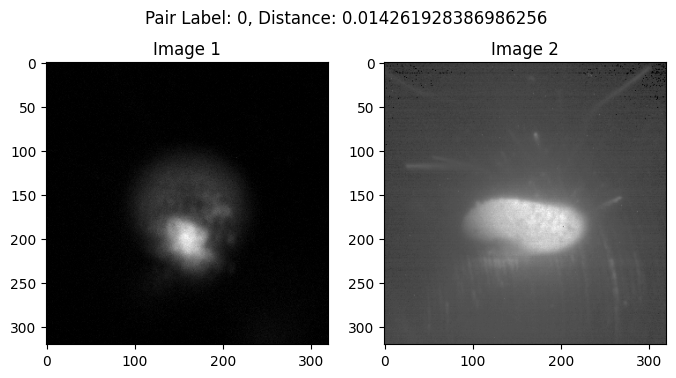

1/1 [==============================] - 0s 34ms/step


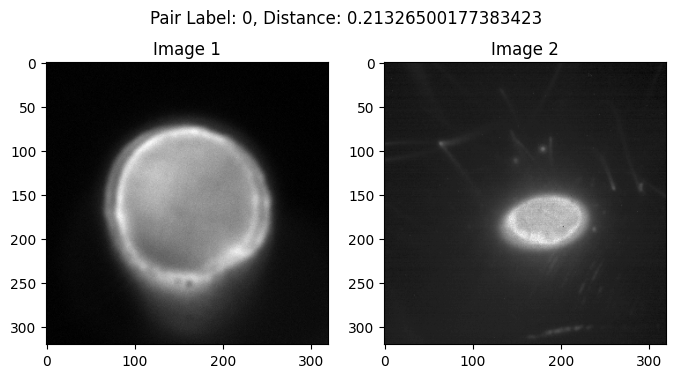

1/1 [==============================] - 0s 20ms/step


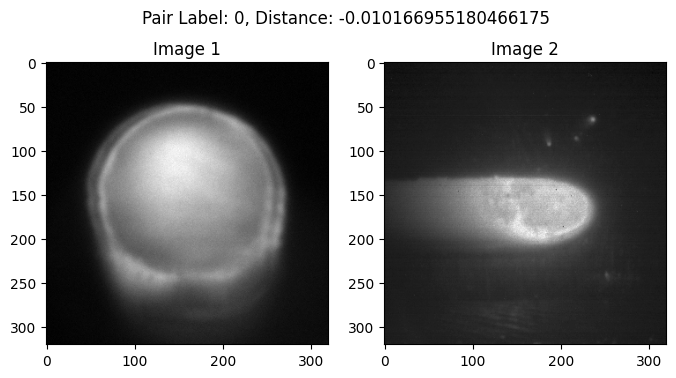

1/1 [==============================] - 0s 20ms/step


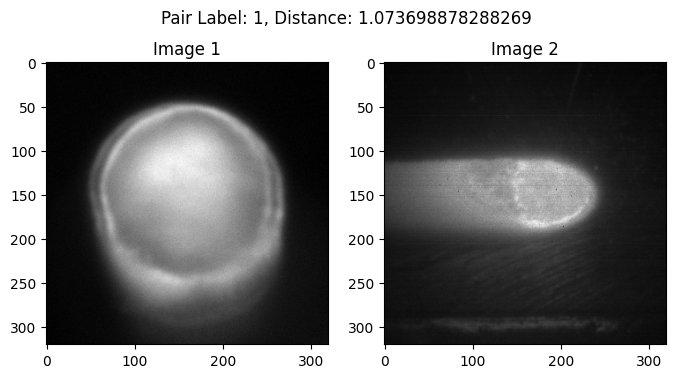

1/1 [==============================] - 0s 20ms/step


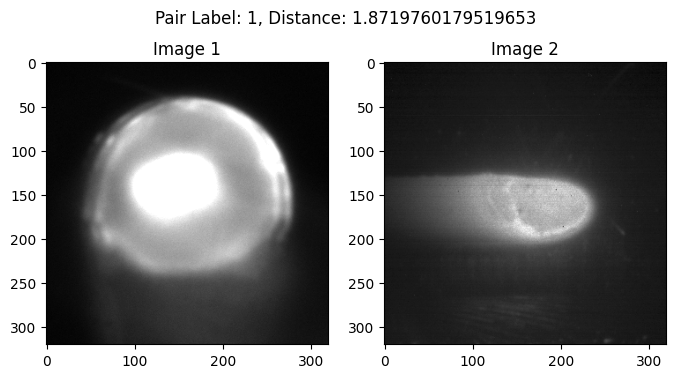

In [ ]:
# with X_test display 3 pairs and their distance
num_samples_to_verify = 5

for i in range(num_samples_to_verify):
    sample_idx = np.random.randint(0, len(X_test))
    pair = X_test[sample_idx]
    label = y_test[sample_idx]

    # Extract images from the pair
    image1, image2 = pair[0], pair[1]

    # Display images with their corresponding label
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.title('Image 1')

    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap='gray')
    plt.title('Image 2')

    

    # Calculate the distance between the two images
    distance = siamese_net.predict([np.expand_dims(image1, axis=0), np.expand_dims(image2, axis=0)])[0][0]
    
    
    plt.suptitle(f"Pair Label: {label[0]}, Distance: {distance}")
    plt.show()

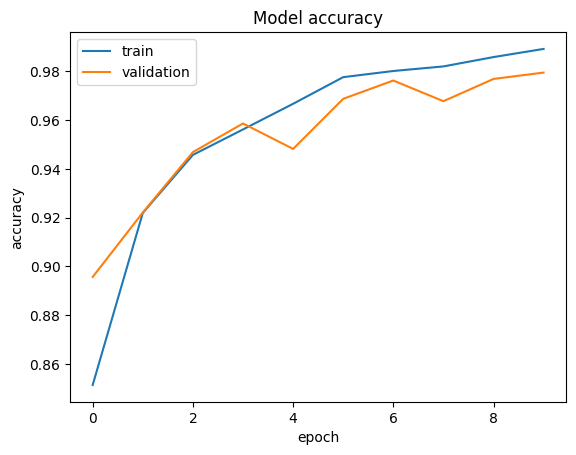

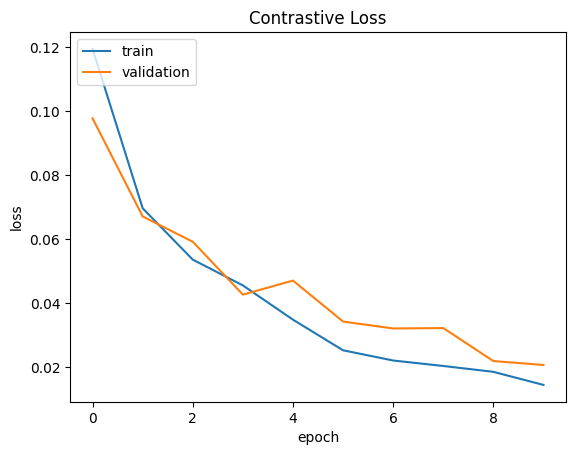

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")


In [ ]:
results = siamese_net.evaluate([X_test[:, 0], X_test[:, 1]], y_test)
print("test loss, test acc:", results)

120/120 [==============================] - 3s 22ms/step - loss: 0.0221 - accuracy: 0.9786
test loss, test acc: [0.022120023146271706, 0.9786179661750793]


120/120 [==============================] - 2s 15ms/step


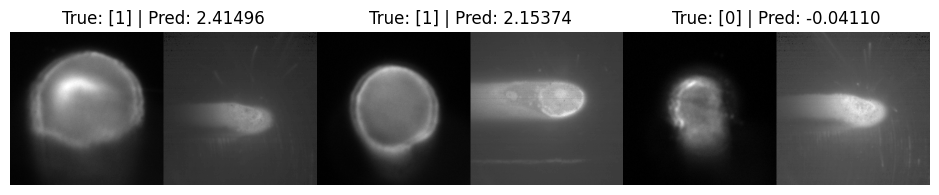

In [ ]:
predictions = siamese_net.predict([X_test[:, 0], X_test[:, 1]])
visualize(X_test, y_test, to_show=3, predictions=predictions, test=True)